## New York City Taxi Fare Prediction

Can you predict a rider's taxi fare?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopy.distance #Python distance measuring package
from tqdm import tqdm
import datetime as dt

## Reading data 
Very large dataset

In [2]:
## Use only latest dates as price indication, since past time is not very reelevant
%time test_df= pd.read_csv('test.csv',parse_dates=['pickup_datetime'])
TRAIN_PATH = 'train.csv'

Wall time: 212 ms


In [22]:
%%time

# Method 2 by @danlester, using wc unix command. Takes only 3 seconds!
s = !wc -l {TRAIN_PATH}

# add one because the file isn't quite correctly formatted as a CSV, should have a final newline char
n_rows = int(s[0].split(' ')[0])+1

print (f'Exact number of rows: {n_rows}')

Exact number of rows: 55423857
Wall time: 2.66 s


In [23]:
# Set columns to most suitable type to optimize for memory usage
traintypes = {'fare_amount': 'float32',
              'pickup_datetime': 'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}

cols = list(traintypes.keys())

chunksize = 5_000_000 # 5 million rows at one go. Or try 10 million

In [24]:
%%time
df_list = [] # list to hold the batch dataframe

for df_chunk in tqdm(pd.read_csv(TRAIN_PATH, usecols=cols, dtype=traintypes, chunksize=chunksize)):
     
    # Neat trick from https://www.kaggle.com/btyuhas/bayesian-optimization-with-xgboost
    # Using parse_dates would be much slower!
    df_chunk['pickup_datetime'] = df_chunk['pickup_datetime'].str.slice(0, 16)
    df_chunk['pickup_datetime'] = pd.to_datetime(df_chunk['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
    
    # Can process each chunk of dataframe here
    # clean_data(), feature_engineer(),fit()
    
    # Alternatively, append the chunk to list and merge all
    df_list.append(df_chunk) 

12it [01:30,  7.51s/it]

Wall time: 1min 30s


In [25]:
# Merge all dataframes into one dataframe
train_df = pd.concat(df_list)

# Delete the dataframe list to release memory
del df_list

# See what we have loaded
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55423856 entries, 0 to 55423855
Data columns (total 7 columns):
fare_amount          float32
pickup_datetime      datetime64[ns, UTC]
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
dtypes: datetime64[ns, UTC](1), float32(5), uint8(1)
memory usage: 1.5 GB


In [26]:
%%time
# Save into feather format, about 1.5Gb. 
train_df.to_feather('nyc_taxi_data_raw.feather')

Wall time: 6.84 s


In [3]:
%%time
# load the same dataframe next time directly, without reading the csv file again!
train_df_new = pd.read_feather('nyc_taxi_data_raw.feather')

Wall time: 2.08 s


In [4]:
train_df = train_df_new
#Error values for Distance
train_df = train_df.drop([792209])
train_df = train_df.drop([54704717])
train_df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:00+00:00,-73.844315,40.721317,-73.841614,40.712276,1
1,16.9,2010-01-05 16:52:00+00:00,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-18 00:35:00+00:00,-73.982735,40.761269,-73.991241,40.750561,2
3,7.7,2012-04-21 04:30:00+00:00,-73.987129,40.733143,-73.991570,40.758091,1
4,5.3,2010-03-09 07:51:00+00:00,-73.968094,40.768009,-73.956657,40.783764,1
...,...,...,...,...,...,...,...
55423851,14.0,2014-03-15 03:28:00+00:00,-74.005272,40.740028,-73.963280,40.762554,1
55423852,4.2,2009-03-24 20:46:00+00:00,-73.957787,40.765530,-73.951637,40.773960,1
55423853,14.1,2011-04-02 22:04:00+00:00,-73.970505,40.752323,-73.960541,40.797340,1
55423854,28.9,2011-10-26 05:57:00+00:00,-73.980904,40.764629,-73.870605,40.773964,1


In [5]:
test_df

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1
...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51.0000002,2015-05-10 12:37:51+00:00,-73.968124,40.796997,-73.955643,40.780388,6
9910,2015-01-12 17:05:51.0000001,2015-01-12 17:05:51+00:00,-73.945511,40.803600,-73.960213,40.776371,6
9911,2015-04-19 20:44:15.0000001,2015-04-19 20:44:15+00:00,-73.991600,40.726608,-73.789742,40.647011,6
9912,2015-01-31 01:05:19.0000005,2015-01-31 01:05:19+00:00,-73.985573,40.735432,-73.939178,40.801731,6


### EDA






c:\users\val\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


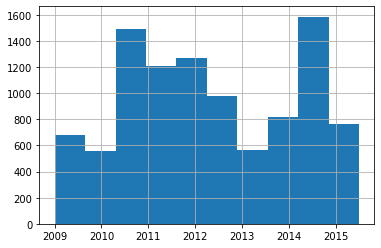

In [6]:
#apparently test data is mixed for various intervals from 2009 to 2015. 
test_df.pickup_datetime.hist()

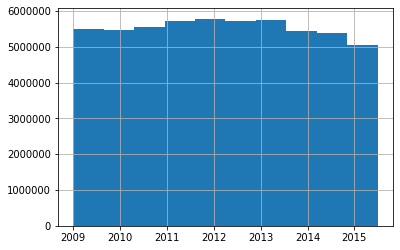

In [7]:
#train data is balanced and also for same intervals
train_df.pickup_datetime.hist()

In [8]:
#remove Outlices Keep only data 6 or less passengers.
train_df.passenger_count.value_counts()

1      38337522
2       8175243
5       3929346
3       2432712
4       1178852
6       1174647
0        195416
208          64
9            23
7            15
8             9
129           2
51            1
49            1
34            1
Name: passenger_count, dtype: int64

In [9]:
#passenger count 0? - Drop maybe
train_df = train_df[(train_df.passenger_count > 0) & (train_df.passenger_count <=6) ]
train_df.passenger_count.value_counts()

1    38337522
2     8175243
5     3929346
3     2432712
4     1178852
6     1174647
Name: passenger_count, dtype: int64

In [10]:
#keep data where fare amount is positive (negative doesn't make any sense)
train_df = train_df[train_df.fare_amount > 0]

In [11]:
train_df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:00+00:00,-73.844315,40.721317,-73.841614,40.712276,1
1,16.9,2010-01-05 16:52:00+00:00,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-18 00:35:00+00:00,-73.982735,40.761269,-73.991241,40.750561,2
3,7.7,2012-04-21 04:30:00+00:00,-73.987129,40.733143,-73.991570,40.758091,1
4,5.3,2010-03-09 07:51:00+00:00,-73.968094,40.768009,-73.956657,40.783764,1
...,...,...,...,...,...,...,...
55423851,14.0,2014-03-15 03:28:00+00:00,-74.005272,40.740028,-73.963280,40.762554,1
55423852,4.2,2009-03-24 20:46:00+00:00,-73.957787,40.765530,-73.951637,40.773960,1
55423853,14.1,2011-04-02 22:04:00+00:00,-73.970505,40.752323,-73.960541,40.797340,1
55423854,28.9,2011-10-26 05:57:00+00:00,-73.980904,40.764629,-73.870605,40.773964,1


In [12]:
## Reduce size of train 100 times
train_df = train_df.iloc[::100]
train_df.shape

(552246, 7)

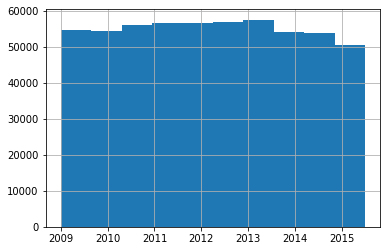

In [13]:
train_df.pickup_datetime.hist()

## Feature engineering

- Distance in KM +
- Time of day (Hours) + 
- Time of week (Mon,Tue) +
- Time of month (Jan, Feb) +

### Distance in KM

In [14]:
# select only correct values
train_df = train_df[(train_df['pickup_latitude'] >= -89) & (train_df['pickup_latitude'] <= 89) ]
train_df = train_df[(train_df['dropoff_latitude'] >= -89) & (train_df['dropoff_latitude'] <= 89) ]
train_df = train_df[(train_df['pickup_longitude'] >= -179) & (train_df['pickup_longitude'] <= 179) ]
train_df = train_df[(train_df['dropoff_longitude'] >= -179) & (train_df['dropoff_longitude'] <= 179) ]
train_df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:00+00:00,-73.844315,40.721317,-73.841614,40.712276,1
100,10.0,2014-11-12 12:40:00+00:00,-74.002579,40.739571,-73.994583,40.760681,1
200,6.0,2013-10-05 09:12:00+00:00,-74.000313,40.747959,-73.993637,40.757229,1
300,12.1,2010-03-27 22:20:00+00:00,-73.870934,40.773705,-73.914268,40.753681,1
401,10.5,2011-10-16 22:37:00+00:00,-73.997269,40.719963,-73.994270,40.754211,1
...,...,...,...,...,...,...,...
55423449,13.7,2010-05-10 14:36:00+00:00,-74.003586,40.713474,-73.995789,40.764729,1
55423549,9.3,2011-06-18 13:45:00+00:00,-73.990410,40.731583,-73.998505,40.745045,1
55423649,10.5,2010-02-28 19:50:00+00:00,-74.008820,40.708858,-73.983376,40.735096,1
55423749,5.3,2009-05-05 20:13:00+00:00,-73.985893,40.741116,-73.988747,40.749302,2


In [15]:
train_df.shape 

(552209, 7)

In [16]:
def distance(row):
    coords_1 = (row['pickup_longitude'], row['pickup_latitude'])
    coords_2 = (row['dropoff_longitude'], row['dropoff_latitude'])
    
    return geopy.distance.geodesic(coords_1, coords_2).km

test_df['distance_km'] = test_df.apply(distance, axis=1)

In [17]:
train_df['distance_km'] = train_df.apply(distance, axis=1)

### Hours of day, Weekday, Month

In [18]:
data = [train_df,test_df]

for dataset in data:
    dataset['hour_of_day'] = dataset.pickup_datetime.dt.hour
    dataset['weekday'] = dataset.pickup_datetime.dt.weekday
    dataset['month'] = dataset.pickup_datetime.dt.month
    dataset['quarter'] = dataset.pickup_datetime.dt.quarter
    dataset['dayofyear'] = dataset.pickup_datetime.dt.dayofyear
    dataset['year'] = dataset.pickup_datetime.dt.year

In [19]:
test_df

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,hour_of_day,weekday,month,quarter,dayofyear,year
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,1.094593,13,1,1,1,27,2015
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,1.474196,13,1,1,1,27,2015
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1,0.357076,11,5,10,4,281,2011
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1,1.150116,21,5,12,4,336,2012
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1,2.875803,21,5,12,4,336,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51.0000002,2015-05-10 12:37:51+00:00,-73.968124,40.796997,-73.955643,40.780388,6,1.484303,12,6,5,2,130,2015
9910,2015-01-12 17:05:51.0000001,2015-01-12 17:05:51+00:00,-73.945511,40.803600,-73.960213,40.776371,6,1.843581,17,0,1,1,12,2015
9911,2015-04-19 20:44:15.0000001,2015-04-19 20:44:15+00:00,-73.991600,40.726608,-73.789742,40.647011,6,22.663427,20,6,4,2,109,2015
9912,2015-01-31 01:05:19.0000005,2015-01-31 01:05:19+00:00,-73.985573,40.735432,-73.939178,40.801731,6,5.567288,1,5,1,1,31,2015


In [20]:
train_df.dtypes

fare_amount                      float32
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float32
pickup_latitude                  float32
dropoff_longitude                float32
dropoff_latitude                 float32
passenger_count                    uint8
distance_km                      float64
hour_of_day                        int64
weekday                            int64
month                              int64
quarter                            int64
dayofyear                          int64
year                               int64
dtype: object

## Model building 

In [21]:
target = 'fare_amount'
features = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude',
            'passenger_count','distance_km','hour_of_day','weekday','month','quarter',
            'dayofyear','year']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_df[target], test_size=0.25)

## Model traininig

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

In [38]:
rf = RandomForestRegressor(n_estimators = 100)

In [39]:
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [40]:
y_predicted = rf.predict(X_test)

### Evalutation based on RMSE

In [41]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_test, y_predicted))
print(rms)

4.4737016991247325


## Model selection

In [ ]:
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

classifiers = [
    svm.SVR(gamma='auto'),
    LinearRegression(),
    Lasso(),
    ElasticNet(),
    DecisionTreeRegressor(),
    KNeighborsRegressor(),
    GradientBoostingRegressor(n_estimators = 100),
    RandomForestRegressor(n_estimators = 100),
    xgb.XGBRegressor(),
    ]
for classifier in classifiers:
    pipe = classifier
    pipe.fit(X_train, y_train)
    y_predicted = pipe.predict(X_test)
    print(classifier)
    print("model rmse: %.3f" %  sqrt(mean_squared_error(y_test, y_predicted)))

c:\users\val\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [43]:
## Pipeline? Do we need to do anything with data, normalize, scale, encode etc?

In [44]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer

In [48]:
answer = rf.predict(test_df[features])

In [52]:
# dataframe with predictions
kaggle = pd.DataFrame({'key':test_df['key'],'fare_amount': answer})

# save to csv
kaggle.to_csv('predictions.csv', index=False)

#1st try Score: 3.32363